In [51]:
import pandas as pd
import numpy as np
import torch
from torch import Tensor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import k_means
import anfis
from membership import membershipfunction

In [52]:

# Load the dataset
file_path = "AirQualityUCI.xlsx"  # Replace with the actual file path
df = pd.read_excel(file_path)

# Replace -200 with NaN for better handling of missing data
df.replace(-200, pd.NA, inplace=True)

# Drop rows with missing data (originally indicated by -200)
df.dropna(inplace=True)

# Reset the index after dropping rows
df.reset_index(drop=True, inplace=True)

# Display the cleaned DataFrame
df.head()


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10,18:00:00,2.6,1360.0,150,11.881723,1045.5,166.0,1056.25,113.0,1692.0,1267.5,13.6,48.875001,0.757754
1,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.3,47.7,0.725487
2,2004-03-10,20:00:00,2.2,1402.0,88,8.997817,939.25,131.0,1140.0,114.0,1554.5,1074.0,11.9,53.975,0.750239
3,2004-03-10,21:00:00,2.2,1375.5,80,9.228796,948.25,172.0,1092.0,122.0,1583.75,1203.25,11.0,60.0,0.786713
4,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.5,131.0,1205.0,116.0,1490.0,1110.0,11.15,59.575001,0.788794


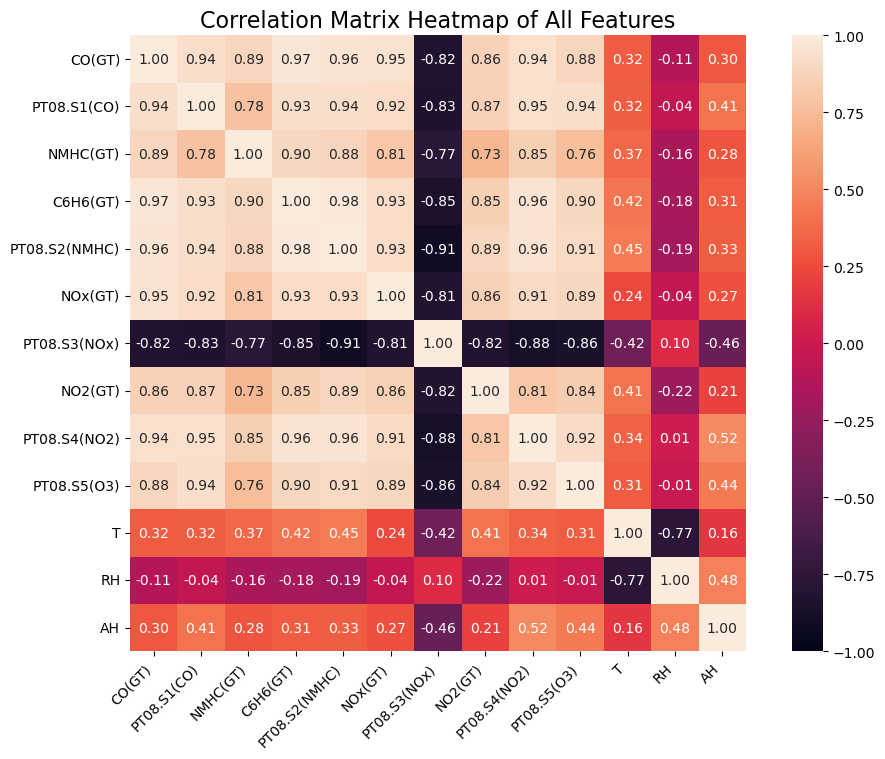

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = df[df.columns[2:]].corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cbar=True, square=True, vmin=-1 , vmax=1)
plt.title('Correlation Matrix Heatmap of All Features', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.show()


In [54]:


# Select features and target
features = ['CO(GT)','C6H6(GT)', 'PT08.S2(NMHC)']  # Example feature columns
target = 'PT08.S1(CO)'  # Target column

X = df[features].to_numpy()
Y = df[target].to_numpy()

# Normalize features and target
scaler_X = MinMaxScaler()
scaler_Y = MinMaxScaler()

X = scaler_X.fit_transform(X)
Y = scaler_Y.fit_transform(Y.reshape(-1, 1)).flatten()

# Step 3: Split the data into train, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.4, random_state=73)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=73)



In [55]:

# Step 4: Define the RBF Model
class RBF():
    def __init__(self, inFeatures: int, outFeatures: int, nClusters: int) -> None:
        self.inFeatures = inFeatures
        self.outFeatures = outFeatures
        self.nCluster = nClusters
        self.weights = None

        # Perform K-Means clustering to find centroids
        self.centroids, _, _ = k_means(x_train, n_clusters=self.nCluster)
        dists = []
        for i in range(self.centroids.shape[0]):
            for j in range(self.centroids.shape[0]):
                if i != j:
                    d = np.linalg.norm(self.centroids[i] - self.centroids[j])
                    dists.append(d)
        dMax = max(dists)
        spread = (dMax ** 2) / (self.nCluster)
        self.scale = -2 * (spread)

    def euclidean(self, X: Tensor, C: Tensor):
        cMat = torch.tensor(np.tile(C, (X.shape[0], 1)))
        diff = torch.norm(X - cMat, dim=1)
        return diff

    def train(self, X: Tensor, y: Tensor):
        phiList = []
        for c in self.centroids:
            r = self.euclidean(X, c)
            phi = torch.exp(r / self.scale)
            phiList.append(phi.unsqueeze(1).permute(1, 0))
        phiT = torch.cat(phiList)
        phis = phiT.permute(1, 0)
        weights = (torch.linalg.inv(phiT @ phis)) @ phiT @ y
        self.weights = weights

    def test(self, X: Tensor):
        phiList = []
        for c in self.centroids:
            r = self.euclidean(X, c)
            phi = torch.exp(r / self.scale)
            phiList.append(phi.unsqueeze(1).permute(1, 0))
        phiT = torch.cat(phiList)
        phis = phiT.permute(1, 0)
        yHat = phis @ self.weights
        return yHat


In [56]:

# Step 5: Train and test the RBF model
rbf = RBF(inFeatures=3, outFeatures=1, nClusters=5)

# Convert data to PyTorch tensors
x_train_torch = torch.tensor(x_train)
y_train_torch = torch.tensor(y_train).unsqueeze(1)
x_test_torch = torch.tensor(x_test)

# Train the RBF model
rbf.train(x_train_torch, y_train_torch)

# Test the RBF model
y_pred_rbf = rbf.test(x_test_torch).detach().numpy()

# Evaluate the RBF model
y_pred_rbf_denorm = scaler_Y.inverse_transform(y_pred_rbf)
y_test_denorm = scaler_Y.inverse_transform(y_test.reshape(-1, 1))

mse_rbf = mean_squared_error(y_test_denorm, y_pred_rbf_denorm)
r2_rbf = r2_score(y_test_denorm, y_pred_rbf_denorm)

print(f"RBF Model - Mean Squared Error: {mse_rbf}")
print(f"RBF Model - R-Squared: {r2_rbf}")


RBF Model - Mean Squared Error: 7853.848859535396
RBF Model - R-Squared: 0.861146314363854


In [57]:

# Step 6: Define and train the ANFIS model
mf = [
    [['gaussmf', {'mean': np.mean(x_train[:, 0]), 'sigma': np.std(x_train[:, 0])}],
     ['gaussmf', {'mean': np.mean(x_train[:, 0]) - 1, 'sigma': np.std(x_train[:, 0]) * 1.5}]],
    [['gaussmf', {'mean': np.mean(x_train[:, 1]), 'sigma': np.std(x_train[:, 1])}],
     ['gaussmf', {'mean': np.mean(x_train[:, 1]) + 1, 'sigma': np.std(x_train[:, 1]) * 1.5}]],
    [['gaussmf', {'mean': np.mean(x_train[:, 2]), 'sigma': np.std(x_train[:, 2])}],
     ['gaussmf', {'mean': np.mean(x_train[:, 2]) - 1, 'sigma': np.std(x_train[:, 2]) * 1.5}]],
]

# Create the ANFIS model
mfc = membershipfunction.MemFuncs(mf)
anf = anfis.ANFIS(x_train, y_train, mfc)

# Train the ANFIS model
anf.trainHybridJangOffLine(epochs=20)


current error: 1.728047259479344
current error: 1.7277293384572032
current error: 1.7274498420628563
current error: 1.7272220277192027
current error: 1.727037273174532
current error: 1.7269192666324114
current error: 1.7268967518263576
current error: 1.7270111739600962
current error: 1.7272938659280626
current error: 1.7277685781726346
current error: 1.7284385715488424
current error: 1.7292648708604845
current error: 1.7302039047265392
current error: 1.7311513417624875
current error: 1.7316990460030517
current error: 1.7317882857804539
current error: 1.729582028314963
current error: 1.7254811351753698
current error: 1.7245244775140647


array([[0.33720093],
       [0.53580258],
       [0.17305642],
       [0.19949319],
       [0.28638746],
       [0.42100052],
       [0.15397287],
       [0.29870849],
       [0.40379542],
       [0.62034869],
       [0.6342786 ],
       [0.42163229],
       [0.11863285],
       [0.18048534],
       [0.43130745],
       [0.40473487],
       [0.51379956],
       [0.18934021],
       [0.1034091 ],
       [0.4248749 ],
       [0.13640013],
       [0.67821582],
       [0.16656499],
       [0.62727192],
       [0.21515043],
       [0.16467588],
       [0.30647177],
       [0.62179938],
       [0.2148956 ],
       [0.49889375],
       [0.58574798],
       [0.08900122],
       [0.78642197],
       [0.19346943],
       [0.26313298],
       [0.42456747],
       [0.19439743],
       [0.49058132],
       [0.34957057],
       [0.14846708],
       [0.50249567],
       [0.42913165],
       [0.52317519],
       [0.39073402],
       [0.14524452],
       [0.38474667],
       [0.10384449],
       [0.170

In [58]:

# Test the ANFIS model
y_pred_anfis = anfis.predict(anf , x_test)

# Evaluate the ANFIS model
y_pred_anfis_denorm = scaler_Y.inverse_transform(y_pred_anfis)
mse_anfis = mean_squared_error(y_test_denorm, y_pred_anfis_denorm)
r2_anfis = r2_score(y_test_denorm, y_pred_anfis_denorm)

print(f"ANFIS Model - Mean Squared Error: {mse_anfis}")
print(f"ANFIS Model - R-Squared: {r2_anfis}")

# Step 7: Compare the models
if mse_rbf < mse_anfis:
    print("The RBF model performed better with a lower MSE.")
else:
    print("The ANFIS model performed better with a lower MSE.")

if r2_rbf > r2_anfis:
    print("The RBF model performed better with a higher R-Squared.")
else:
    print("The ANFIS model performed better with a higher R-Squared.")

ANFIS Model - Mean Squared Error: 6819.833311638766
ANFIS Model - R-Squared: 0.8794273982500316
The ANFIS model performed better with a lower MSE.
The ANFIS model performed better with a higher R-Squared.


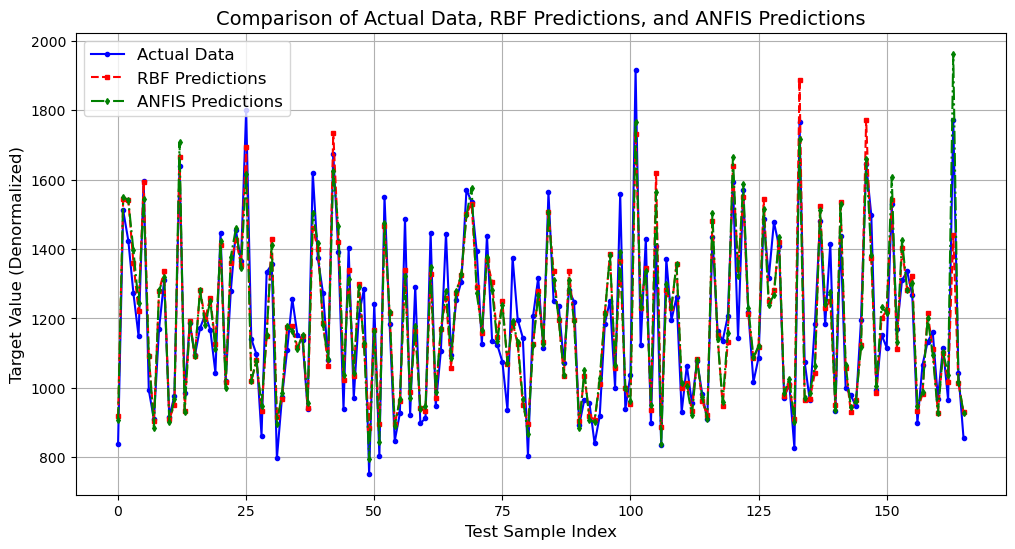

In [59]:
import matplotlib.pyplot as plt


# Plot RBF, ANFIS, and actual test results
plt.figure(figsize=(12, 6))

# Plot actual data
plt.plot(y_test_denorm, label='Actual Data', linestyle='-', marker='o', markersize=3, color='blue')

# Plot RBF predictions
plt.plot(y_pred_rbf_denorm, label='RBF Predictions', linestyle='--', marker='s', markersize=3, color='red')

# Plot ANFIS predictions
plt.plot(y_pred_anfis_denorm, label='ANFIS Predictions', linestyle='-.', marker='d', markersize=3, color='green')

# Add labels and legend
plt.title('Comparison of Actual Data, RBF Predictions, and ANFIS Predictions', fontsize=14)
plt.xlabel('Test Sample Index', fontsize=12)
plt.ylabel('Target Value (Denormalized)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()
